# Data Processing
This file runs through the data and processes it into a usable format for the training of the language model and reward model.

This involves the following steps:
1. Removing all rows where the column *"black_card_pick_num"* is over 1, to ensure that chosen rows only contain one punchline.
2. Erasing rows where *"round_skipped"* is True, to ensure that chosen rows actually have a winning joke.
3. Adding an extra row into the dataset containing the winning joke for that round. This becomes useful for the reward model training.
4. Mapping *"won"* values of False to 0, and True to 1 to aid with training further down the line.
5. Columns containing data that is not immediately relevant are removed and *"fake_round_id"* is renamed to *"round_id"*.

---
### Dataset Pre-processing:

In [11]:
# Imports the Pandas library
import pandas as pd

# Reads the .csv file and then omits certain rows based on conditions.
dataset = pd.read_csv('Data/cah_data.csv')
dataset = dataset[dataset['black_card_pick_num'] <= 1]
dataset = dataset[dataset['round_skipped'] != True]

# Creates a new column for the winning joke.
winning_jokes = dataset[dataset['won'] == True].copy()
winning_jokes.loc[:, 'chosen_white_card'] = winning_jokes['white_card_text']
dataset = pd.merge(dataset, winning_jokes[['fake_round_id', 'chosen_white_card']], on='fake_round_id', how='left')

# Creates a column with cleaned white_card_text.
def remove_period(input):
    if input[-1] == '.':
        if input[-2] != '.':
            input = input[:-1]
    else:
        if input[-2] == '.' and input[-3] != '.':
            input = input[:-2] + input[-1]
    return input
dataset['clean_white_card_text'] = dataset['white_card_text'].apply(remove_period)

# Alters other features within the dataset, as specified above, to aid with future tasks.
dataset['won'] = dataset['won'].map({False: 0, True: 1})
dataset['won'] = dataset['won'].astype(float)
dataset.drop(['winning_index', 'round_skipped', 'black_card_pick_num'], axis=1, inplace=True)
dataset.rename(columns={'fake_round_id': 'round_id'}, inplace=True)

# Saves the dataset into a new .csv file.
dataset.to_csv('Data/pproc_cah_data.csv', index=False)

In [12]:
dataset

,round_id,round_completion_seconds,black_card_text,white_card_text,won,chosen_white_card,clean_white_card_text
0,1,24,"Hi MTV! My name is Kendra, I live in Malibu, I...",Going inside at some point because of the mosq...,0.0,Shapes and colors.,Going inside at some point because of the mosq...
1,1,24,"Hi MTV! My name is Kendra, I live in Malibu, I...",Being fat from noodles.,0.0,Shapes and colors.,Being fat from noodles
2,1,24,"Hi MTV! My name is Kendra, I live in Malibu, I...",Letting this loser eat me out.,0.0,Shapes and colors.,Letting this loser eat me out
3,1,24,"Hi MTV! My name is Kendra, I live in Malibu, I...",That chicken from Popeyes.®,0.0,Shapes and colors.,That chicken from Popeyes®
4,1,24,"Hi MTV! My name is Kendra, I live in Malibu, I...",A sorry excuse for a father.,0.0,Shapes and colors.,A sorry excuse for a father
...,...,...,...,...,...,...,...
2446355,298955,7613,Oh my god! _____ killed Kenny!,Breastfeeding a ten-year-old.,0.0,Jeff Bezos.,Breastfeeding a ten-year-old
2446356,298955,7613,Oh my god! _____ killed Kenny!,Happy daddies with happy sandals.,0.0,Jeff Bezos.,Happy daddies with happy sandals
2446357,298955,7613,Oh my god! _____ killed Kenny!,Jerking off to a 10-second RealMedia clip.,0.0,Jeff Bezos.,Jerking off to a 10-second RealMedia clip
2446358,298955,7613,Oh my god! _____ killed Kenny!,Getting naked and watching Nickelodeon.,0.0,Jeff Bezos.,Getting naked and watching Nickelodeon


In [64]:
# Filters out any rows outside of the 25th and 75th percentiles of round completion seconds.
percentile_25 =  dataset['round_completion_seconds'].quantile(0.25)
percentile_75 = dataset['round_completion_seconds'].quantile(0.75)

# Filter the dataframe to keep only the rows within the middle 50% of integer values
dataset = dataset[
    (dataset['round_completion_seconds'] >= percentile_25) &
    (dataset['round_completion_seconds'] <= percentile_75)
]

dataset.to_csv('Data/proc_cah_data.csv', index=False)

In [65]:
print(dataset)

         round_id  round_completion_seconds  \
0               1                        24   
1               1                        24   
2               1                        24   
3               1                        24   
4               1                        24   
...           ...                       ...   
2446345    298954                        18   
2446346    298954                        18   
2446347    298954                        18   
2446348    298954                        18   
2446349    298954                        18   

                                           black_card_text  \
0        Hi MTV! My name is Kendra, I live in Malibu, I...   
1        Hi MTV! My name is Kendra, I live in Malibu, I...   
2        Hi MTV! My name is Kendra, I live in Malibu, I...   
3        Hi MTV! My name is Kendra, I live in Malibu, I...   
4        Hi MTV! My name is Kendra, I live in Malibu, I...   
...                                                    ...   
2

---
### Data split generation
Several functions are provided here for generating splits of data for the purpose of training.
1. gen_split: generates a training and testing split of the data based on a defined size.
2. gen_unseen: achieves the same purpose as gen_split, but ensures that the testing split has no common winning punchlines with the training split.
3. gen_unique: generates a split where no punchlines are shared between the splits of the data.
4. gen_random: randomly generates new data from the punchlines and prompts present in the original data.
5. gen_complete: generates a split of a defined size that does not contain rounds present in two priorly defined splits.


In [4]:
import random
import pandas as pd

# Splits the data into .csvs for a defined train/test size.
def gen_split(dataset, test_size=0.2, val_size=0.1, name="cah_data"):
    # Grabs the unique round IDs in the full dataset.
    round_ids = dataset['round_id'].unique()

    # Splits the dataset into 20% and 80% for use when using the training split.
    random.seed(523)

    val_split_ids = random.sample(list(round_ids), int(len(round_ids) * val_size))
    round_ids = list(set(round_ids) - set(val_split_ids))

    test_split_ids = random.sample(list(round_ids), int(len(round_ids) * test_size))
    train_split_ids = list(set(round_ids) - set(test_split_ids))

    # Converts the splits into .csv files.
    dataset[dataset['round_id'].isin(val_split_ids)].to_csv(f'Data/val_{name}.csv', index=False)
    dataset[dataset['round_id'].isin(test_split_ids)].to_csv(f'Data/testtest_{name}.csv', index=False)
    dataset[dataset['round_id'].isin(train_split_ids)].to_csv(f'Data/train_{name}.csv', index=False)

gen_split(dataset, name="cah_data")

In [8]:
import numpy as np

# Generates splits of the data, where winning punchlines are distinct between splits.
def gen_unseen(dataset, train_size=0.8, name="unseen_data"):
    punchlines = {}
    for _, row in dataset[dataset['won'] == 1].iterrows():
        text = row['white_card_text']
        if text not in punchlines:
            punchlines[text] = []
        punchlines[text].append(row)

    training_rows = []
    testing_rows = []
    training_texts = set()
    testing_texts = set()

    for text, rows in punchlines.items():
        if np.random.rand() < train_size:
            if len(training_texts) + len(rows) <= train_size * len(dataset):
                training_rows.extend(rows)
                training_texts.add(text)
            else:
                testing_rows.extend(rows)
                testing_texts.add(text)
        else:
            if len(testing_texts) + len(rows) <= (1 - train_size) * len(dataset):
                testing_rows.extend(rows)
                testing_texts.add(text)
            else:
                training_rows.extend(rows)
                training_texts.add(text)

    training_split = pd.DataFrame(training_rows)
    train_ids = training_split["round_id"].unique()
    training_split = dataset[dataset["round_id"].isin(train_ids)]

    testing_split = pd.DataFrame(testing_rows)
    test_ids = testing_split["round_id"].unique()
    testing_split = dataset[dataset["round_id"].isin(test_ids)]

    training_split.to_csv(f"Data/Unseen/train_{name}.csv", index=False)
    testing_split.to_csv(f"Data/Unseen/test_{name}.csv", index=False)

gen_unseen(dataset)

In [4]:
# Purely for experimental purposes, generates a data split where punchlines in one do not appear at all in the other - regardless of whether they win or not.
def gen_unique(train_size=60, name="unique_data"):
    round_ids = dataset['round_id'].unique()

    ids = pd.Series(round_ids).sample(n=train_size, random_state=None)
    d_dataset = dataset[dataset['round_id'].isin(ids)].reset_index(drop=True)

    u_dataset = dataset[~dataset['white_card_text'].isin(d_dataset['white_card_text'].unique())].reset_index(drop=True)
    round_count = u_dataset["round_id"].value_counts()
    round_ids = round_count[round_count == 10].index
    t_dataset = dataset[dataset["round_id"].isin(round_ids)]

    d_dataset.to_csv(f"Data/Unique/test_{name}.csv", index=False)
    t_dataset.to_csv(f"Data/Unique/train_{name}.csv", index=False)

gen_unique()

In [6]:
import pandas as pd
import csv
import random

# Generates randomly generated data from the original data, before converting it into a .csv.
def gen_random(dataset, size=0.2, name="cah_data"):
    prompts = dataset['black_card_text'].unique()
    punchlines = dataset['white_card_text'].unique()

    random.seed(523)
    with open(f'Data/random_{name}.csv', 'w', encoding='UTF8', newline="") as f:
        writer = csv.writer(f)
        writer.writerow(['round_id','black_card_text','white_card_text','won','chosen_white_card'])

        # For the specified number of rounds, samples a prompt and ten punchlines.
        for n in range(int(size * (len(dataset)/10))):
            prompt = random.choice(prompts)
            punchline = [random.choice(punchlines) for num in range(0,10)]

            for num in range(0,10):
                writer.writerow([n + 1, prompt, punchline[num], 0.0, punchline[num]])

    # Removes periods from the white cards/punchlines and adds them into a new column.
    random_dataset = pd.read_csv(f'Data/random_{name}.csv')
    def remove_period(input):
        if input[-1] == '.':
            if input[-2] != '.':
                input = input[:-1]
        else:
            if input[-2] == '.' and input[-3] != '.':
                input = input[:-2] + input[-1]
        return input
    random_dataset['clean_white_card_text'] = random_dataset['white_card_text'].apply(remove_period)
    random_dataset.to_csv(f'Data/random_{name}.csv', index=False)

dataset = pd.read_csv('Data/train_cah_data.csv')
gen_random(dataset)

In [15]:
import pandas as pd
import random

# Creates a data split that contains un-trimmed rows of the data, of a similar size to another split.
def gen_complete(name="cah_data"):
    # Ensures that the data we select rounds from does not contain rounds in the validation or training splits.
    dataset = pd.read_csv(f'Data/pproc_{name}.csv')

    train = pd.read_csv(f'Data/train_{name}.csv')
    val = pd.read_csv(f'Data/val_{name}.csv')
    test = pd.read_csv(f'Data/test_{name}.csv')

    train_ids = train['round_id'].unique()
    val_ids = val['round_id'].unique()
    test_ids = test['round_id'].unique()

    ids = dataset[~dataset["round_id"].isin(train_ids)]['round_id'].unique()
    dataset = dataset[dataset['round_id'].isin(ids)].reset_index(drop=True)

    ids = dataset[~dataset["round_id"].isin(val_ids)]['round_id'].unique()
    dataset = dataset[dataset['round_id'].isin(ids)].reset_index(drop=True)

    # Randomly selects rounds to match the length of the test data split.
    random.seed(523)

    round_ids = dataset['round_id'].unique()
    random_ids = random.sample(list(round_ids), int(len(test_ids)))

    # Converts the split into a .csv file.
    dataset[dataset['round_id'].isin(random_ids)].to_csv(f'Data/complete_test_{name}.csv', index=False)

gen_complete()

---
### Dataset properties
We check some properties of the data here to assist with setting up models for training.

We check for:
1. The maximum potential length of a joke to ensure that the tokenizers can accommodate for every joke.
2. If, and which, white cards/punchlines contain periods in their last two characters.
3. The distribution of win-rates amongst punchlines in data splits.
4. Self-evaluation/human performance on the data.

In [69]:
# Calculates the maximum length a joke can manifest as. This is useful for optimising the model training processes.
prompt_len = dataset['white_card_text'].str.len()
max_length = prompt_len.max()

prompt_len = dataset['black_card_text'].str.len()
max_length += prompt_len.max()

max_length

332

In [72]:
filtered_dataset = dataset[dataset['clean_white_card_text'].str[-2:].str.contains('\.')]['white_card_text'].unique()
print(filtered_dataset)

['Staring at a painting and going "hmmmmmm..."']


In [18]:
dataset = pd.read_csv(f'Data/complete_test_cah_data.csv')

train = pd.read_csv(f'Data/train_cah_data.csv')['round_id'].unique()
val = pd.read_csv(f'Data/val_cah_data.csv')['round_id'].unique()

print(dataset[dataset["round_id"].isin(train)])
print(dataset[dataset["round_id"].isin(val)])

Empty DataFrame
Columns: [round_id, round_completion_seconds, black_card_text, white_card_text, won, chosen_white_card, clean_white_card_text]
Index: []
Empty DataFrame
Columns: [round_id, round_completion_seconds, black_card_text, white_card_text, won, chosen_white_card, clean_white_card_text]
Index: []


In [52]:
import pandas as pd
import nltk, string
from tqdm import tqdm
from collections import defaultdict
from nltk.corpus import WordNetCorpusReader
from nltk.stem import WordNetLemmatizer

def clean_joke(joke, lemmatizer, translator):
    words = nltk.word_tokenize(joke)

    words = [word.lower() for word in words]

    words = [lemmatizer.lemmatize(word) for word in words]
    words = [word.translate(translator) for word in words if word.isalnum()]

    return words

def load_wordnet():
    domain2synsets = defaultdict(list)
    synset2domains = defaultdict(list)
    for i in open('Data/WordNet/wn-domains-3.2-20070223', 'r'):
        ssid, doms = i.strip().split('\t')
        doms = doms.split()
        synset2domains[ssid] = doms
        for d in doms:
            domain2synsets[d].append(ssid)

    return domain2synsets, synset2domains

# Adds stylistic metrics to the data splits.
def add_metrics(dataset):
    nltk.download('wordnet')
    nltk.download('punkt')

    lemmatizer = WordNetLemmatizer()
    translator = str.maketrans('', '', string.punctuation)
    wn = WordNetCorpusReader(f'Data/WordNet/dict', 'WordNet/dict')
    domain2synsets, synset2domains = load_wordnet()

    dataset.drop(columns=['inputs','domain_ratio'], errors='ignore', inplace=True)
    dataset['inputs'] = dataset.apply(lambda row: row['black_card_text'].replace("_____", row['chosen_white_card'])
                                   if "_____" in row['black_card_text']
                                   else row['black_card_text'] + " " + row['chosen_white_card'], axis=1)

    domain_total = 0
    for index, joke in tqdm(dataset.iterrows(), desc="Progress"):
        joke = joke['inputs']
        words = clean_joke(joke, lemmatizer, translator)
        word_len = len(words)
        domain_count = 0

        for word in words:
            word_domains = []
            word_synsets = wn.synsets(word)
            for synset in word_synsets:
                word_domains.extend(synset2domains.get(str(synset.offset()).zfill(8) + "-" + synset.pos(), set()))

            if "sexuality" in word_domains or "politics" in word_domains:
                domain_count += 1
        domain_count /= word_len
        domain_total += domain_count

        dataset.at[index, 'domain_ratio'] = domain_count

    domain_total /= len(dataset['inputs'])
    print("Average ratio of sexuality/politics: ", domain_total)

    dataset.drop(columns=['inputs'], errors='ignore', inplace=True)
    dataset.to_csv(f"Data/test_cah_data.csv", index=False)

dataset = pd.read_csv("Data/test_cah_data.csv")
add_metrics(dataset)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\daivi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\daivi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Progress: 229940it [01:36, 2384.18it/s]


Average ratio of sexuality/politics:  0.0599882239994463


In [20]:
import pandas as pd

# Adds win-rates associated with each white card to each row, as a new column.
def add_winrate(name="test_cah_data", train="train_cah_data"):
    dataset = pd.read_csv(f'Data/{name}.csv')
    train_dataset = pd.read_csv(f'Data/{train}.csv')

    total_counts = train_dataset['white_card_text'].value_counts().reset_index()
    total_counts.columns = ['white_card_text', 'total_count']

    win_counts = train_dataset.groupby('white_card_text')['won'].sum().reset_index()
    win_counts.columns = ['white_card_text', 'win_count']

    merged = pd.merge(total_counts, win_counts, on='white_card_text', how='left')
    merged['win_rate'] = merged['win_count'] / merged['total_count']
    train_dataset = pd.merge(train_dataset, merged[['white_card_text', 'win_rate']], on='white_card_text', how='left')

    train_dataset['normalized_text'] = train_dataset['white_card_text'].str.replace(r'\s+', ' ', regex=True).str.strip()
    dataset['normalized_text'] = dataset['white_card_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

    mapping = train_dataset.drop_duplicates(subset='normalized_text').set_index('normalized_text')['win_rate'].fillna(0)
    dataset['win_rate'] = dataset['normalized_text'].map(mapping).fillna(mapping.mean())

    train_dataset.drop(columns=['normalized_text'], inplace=True)
    dataset.drop(columns=['normalized_text'], inplace=True)

    dataset.to_csv(f"Data/{name}.csv", index=False)

add_winrate("test_cah_data", "train_cah_data")

In [14]:
import pandas as pd

# Gets the top punchlines by win-rate for the trimmed data.
dataset = pd.read_csv("Data/train_cah_data.csv")


dataset['row_count'] = dataset.groupby('white_card_text')['white_card_text'].transform('count')
dataset['win_count'] = dataset.groupby('white_card_text')['won'].transform('sum')
dataset['win_rate'] = dataset['win_count']/dataset['row_count']

sorted_dataset = dataset.sort_values(by='win_rate', ascending=False)
high_wr_punchline = sorted_dataset.drop_duplicates(subset='white_card_text')

counts = []
for _, row in high_wr_punchline.iterrows():
    white_card_text = row['white_card_text']
    row_count = dataset[dataset['white_card_text'] == white_card_text].shape[0]
    win_count = dataset[(dataset['white_card_text'] == white_card_text) & (dataset['won'] == 1)].shape[0]
    counts.append([white_card_text, row['win_rate'], row_count, win_count])

result = pd.DataFrame(counts, columns=['white_card_text', 'win_rate', 'row_count', 'win_count'])
result.to_csv("Data/Analysis/train_wrs.csv", index=False)

In [ ]:
import pandas as pd
from datasets import Dataset
from tqdm import tqdm

# Adds self-evaluation results to the data, based on the preferences of the user.
def add_self_eval(dataset):
    if 'user_choice' not in dataset.columns:
        dataset['user_choice'] = None

    itr_dataset = pd.DataFrame.copy(dataset)
    itr_dataset['inputs'] = dataset.apply(lambda row: row['black_card_text'].replace("_____", row['clean_white_card_text'])
                                       if "_____" in row['black_card_text']
                                       else row['black_card_text'] + " " + row['white_card_text'], axis=1)
    itr_dataset = [Dataset.from_pandas(group) for _, group in itr_dataset.groupby('round_id')]

    for batch in tqdm(itr_dataset, desc="Evaluation progress"):
        if batch['user_choice'][0] is not None:
            continue

        jokes = ""

        for index, joke in enumerate(batch['inputs']):
            jokes = f"{jokes} {index}. {joke} \n"
        print(jokes)

        choice = input(f"{jokes}\nEnter choice: ")
        if not choice:
            break
        print(f"Chose {choice}.")

        dataset.loc[dataset['round_id'] == batch['round_id'][0], 'user_choice'] = choice
        dataset.to_csv(f"Data/small_test_cah_data.csv", index=False)

dataset = pd.read_csv(f'Data/small_test_cah_data.csv')
add_self_eval(dataset)

In [7]:
df = pd.read_csv('Data/smaller_test_cah_data.csv')
print(len(df['round_id'].unique()))
# unique_round_ids = df['round_id'].unique()[:100]
# filtered_df = df[df['round_id'].isin(unique_round_ids)]
# filtered_df.to_csv('Data/smaller_test_cah_data.csv', index=False)

100


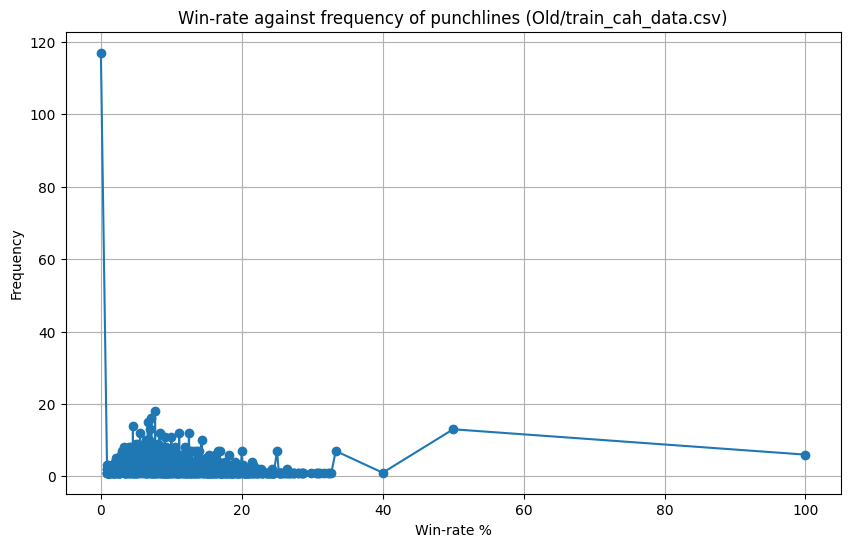

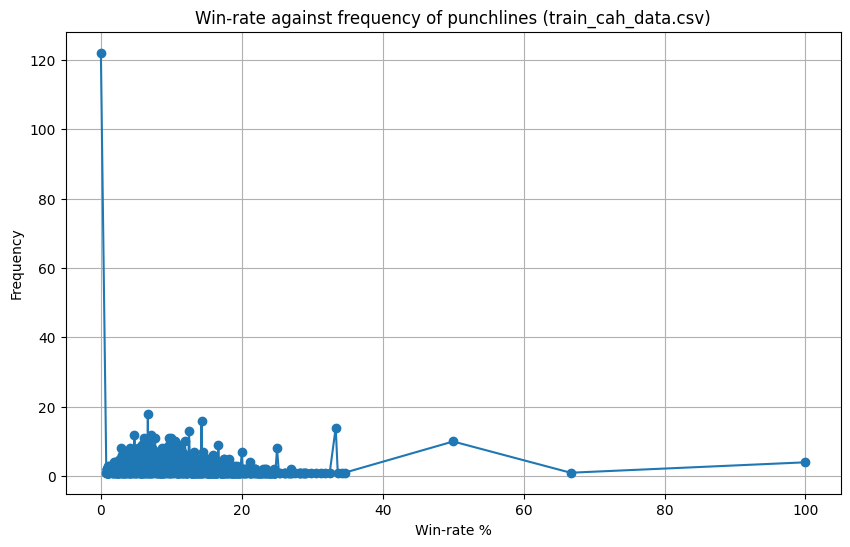

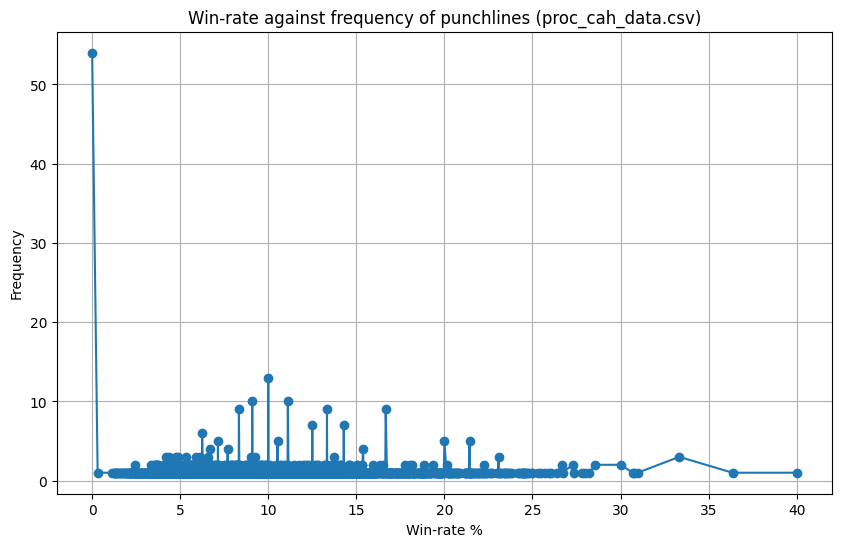

In [20]:
import matplotlib.pyplot as plt

def plot_wr(name='proc_cah_data.csv'):
    dataset = pd.read_csv(f'Data/{name}')
    dataset_grouped = dataset.groupby("white_card_text")["won"].agg(["sum", "count"]).reset_index()
    dataset_grouped["win_rate"] = dataset_grouped["sum"] / dataset_grouped["count"] * 100

    wr_counts = dataset_grouped.groupby("win_rate")["white_card_text"].count().reset_index()

    plt.figure(figsize=(10, 6))
    plt.plot(wr_counts["win_rate"], wr_counts["white_card_text"], marker="o", linestyle="-")
    plt.xlabel("Win-rate %")
    plt.ylabel("Frequency")
    plt.title(f"Win-rate against frequency of punchlines ({name})")
    plt.grid(True)
    plt.show()

# plot_wr(name='Experimental Data/train_unseen_0.1.csv')
# plot_wr(name='Unseen/train_unseen_data.csv')
# plot_wr(name='Unique/train_unique_data.csv')
plot_wr(name='Old/train_cah_data.csv')
plot_wr(name='train_cah_data.csv')
plot_wr(name='proc_cah_data.csv')

# Other datasets

### Reddit Dataset

In [13]:
# Imports the Pandas library
import pandas as pd
from sklearn.model_selection import train_test_split

def normalize(enteredValue, minEntry, maxEntry, normalizedMin, normalizedMax):
    mx = (enteredValue-minEntry)/(maxEntry-minEntry)
    preshiftNormalized = mx*(normalizedMax-normalizedMin)
    shiftedNormalized = preshiftNormalized + normalizedMin

    return shiftedNormalized

dataset = pd.read_csv('Data/Experimental Data/reddit_data.csv')

dataset = dataset[dataset['score'] < 500000]
max_score = dataset['score'].max()
min_score = dataset['score'].min()

dataset['normalized_score'] = dataset['score'].apply(lambda x: normalize(x, min_score, max_score, 0, 1))
train_df, test_df = train_test_split(dataset, test_size=0.1, random_state=None)
train_df, test_df = train_test_split(test_df, test_size=0.2, random_state=None)

train_df.to_csv('Data/Experimental Data/train_reddit_data.csv', index=False)
test_df.to_csv('Data/Experimental Data/test_reddit_data.csv', index=False)

### Humicroedit Dataset

In [21]:
# Imports the Pandas library
import pandas as pd
import re

# Merges the two datasets together.
data1 = pd.read_csv('Data/Microedit/Old/train.csv')
data2 = pd.read_csv('Data/Microedit/Old/train_funlines.csv')
dataset = pd.concat([data1, data2], ignore_index=True)

test_dataset = pd.read_csv('Data/Microedit/Old/test.csv')

# Converts the words to be edited into "_____" to match with the Cards Against Humanity dataset.
def convert_values(row):
    pattern = r'<([^>]*)/>'
    return re.sub(pattern, "_____", row['original'])

# Apply the function to convert the column's values.
dataset['original'] = dataset.apply(convert_values, axis=1)
test_dataset['original'] = dataset.apply(convert_values, axis=1)

dataset.rename(columns={'original': 'black_card_text', 'edit': 'white_card_text', 'meanGrade': 'won'}, inplace=True)
test_dataset.rename(columns={'original': 'black_card_text', 'edit': 'white_card_text', 'meanGrade': 'won'}, inplace=True)

dataset.drop(['grades', 'id'], axis=1, inplace=True)
test_dataset.drop(['grades', 'id'], axis=1, inplace=True)

# Assigns round_ids to groups of ten rows.
dataset['round_id'] = (dataset.index // 10) + 1
test_dataset['round_id'] = (test_dataset.index // 10) + 1

# Excess rows that cannot fit into a group of ten are discarded.
group_sizes = dataset.groupby('round_id').size()
valid_round_ids = group_sizes[group_sizes == 10].index
dataset = dataset[dataset['round_id'].isin(valid_round_ids)]
dataset = dataset[dataset.groupby('round_id')['round_id'].transform('size') == 10]

group_sizes = test_dataset.groupby('round_id').size()
valid_round_ids = group_sizes[group_sizes == 10].index
test_dataset = test_dataset[test_dataset['round_id'].isin(valid_round_ids)]
test_dataset = test_dataset[test_dataset.groupby('round_id')['round_id'].transform('size') == 10]

dataset.to_csv('Data/Microedit/train_micro_data.csv', index=False)
test_dataset.to_csv('Data/Microedit/test_micro_data.csv', index=False)